# Banking dataset with a `pymc` model

This notebook analyses historic data on banking closures from {cite:t}`richardson2009monetary` and used as a case study for a difference in differences analysis in the excellent book [Mastering Metrics](http://www.masteringmetrics.com) {cite:p}`angrist2014mastering`. Here, we replicate this analysis, but using Bayesian inference.

In [1]:
import warnings

import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42
warnings.simplefilter(action="ignore", category=FutureWarning)

## Load data

The raw dataset has a `date` column which is just some uninterpretable number - all we need for our analysis is the `year` column. We also have columns `bib6`, `bio6`, `bib8`, `bio8`. We know that the `6` and `8` represent the 6th and 8th Federal Reserve districts, respectively. I assume `bib` means "banks in business", so we'll keep those columns. The data is at daily resolution, but we will convert this to yearly resolution. And from what I can tell from Figure 5.2 of {cite:t}`angrist2014mastering`, they seem to present the _median_ number of banks open per year. Let's load the data up and do those steps.

In [3]:
df = (
    cp.load_data("banks")
    # just keep columns we want
    .filter(items=["bib6", "bib8", "year"])
    # rename to meaningful variables
    .rename(columns={"bib6": "Sixth District", "bib8": "Eighth District"})
    # reduce from daily resolution to examine median banks open by year
    .groupby("year")
    .median()
)

treatment_time = 1930.5

# set treatment time to zero
df.index = df.index - treatment_time
treatment_time = 0

Let's visualise what we have. This matches up exactly with Figure 5.2 of the {cite:t}`angrist2014mastering`.

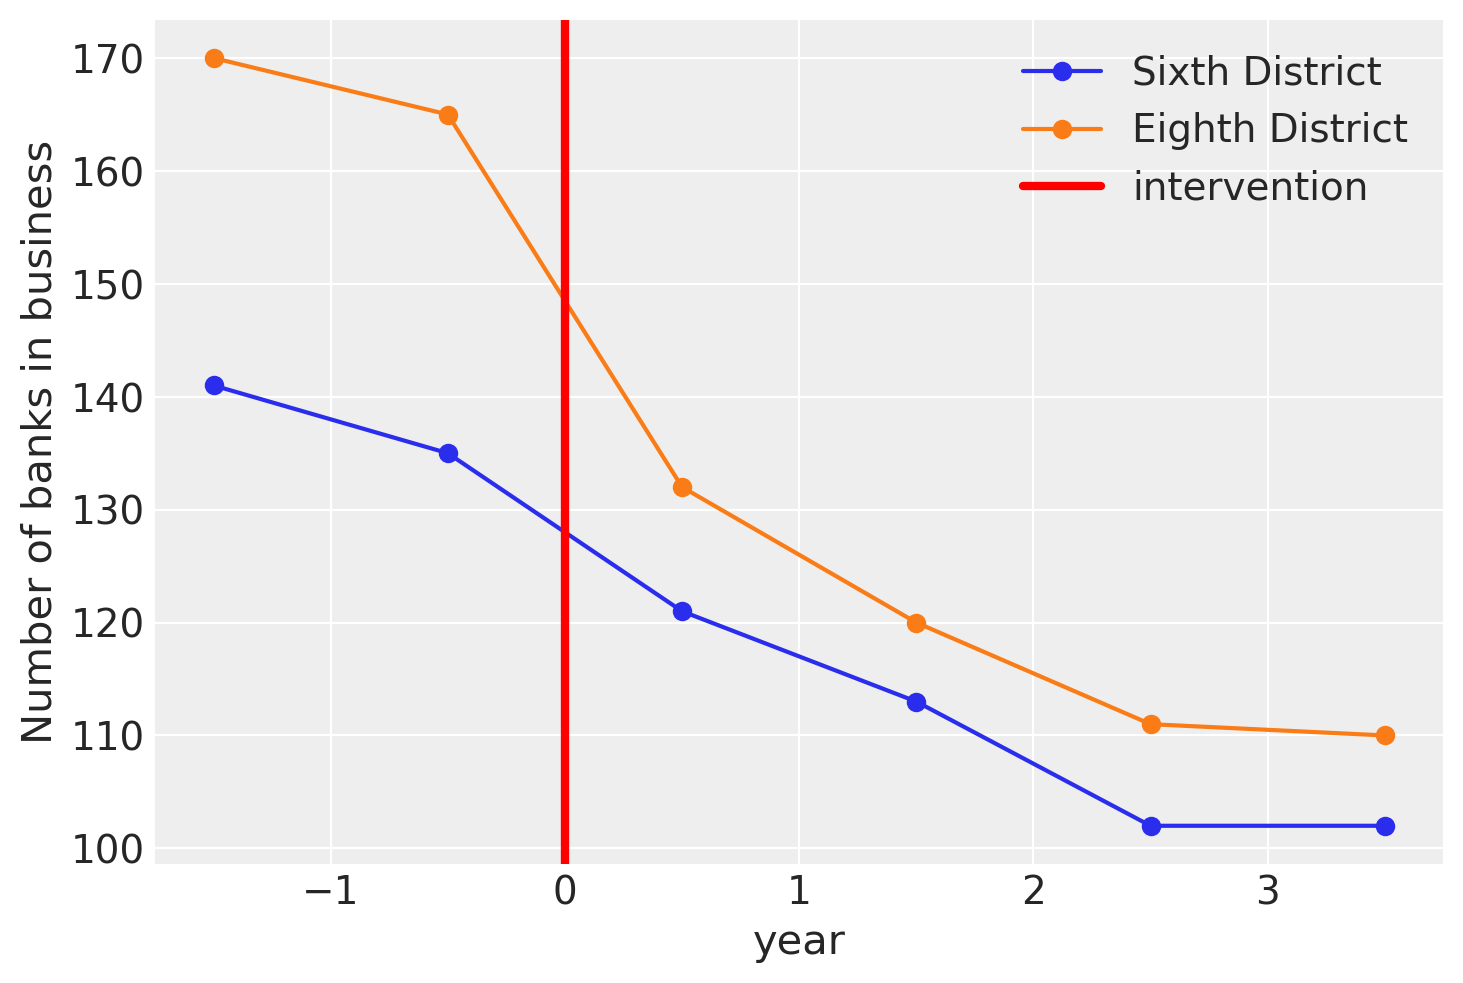

In [4]:
ax = df[["Sixth District", "Eighth District"]].plot(style="o-")
ax.set(ylabel="Number of banks in business")
ax.axvline(x=treatment_time, c="r", lw=3, label="intervention")
ax.legend();

Just a few more final processing steps to make the data amenable to analysis. We will convert from wide form into long form. Then we will add a new column `treated` which indicates the observations where treatment has taken place.

In [5]:
df.reset_index(level=0, inplace=True)
df_long = (
    pd.melt(
        df,
        id_vars=["year"],
        value_vars=["Sixth District", "Eighth District"],
        var_name="district",
        value_name="bib",
    )
    .sort_values("year")
    .reset_index()
)

# We also need to create a column called `unit` which labels each distinct
# unit. In our case we just have two treatment units (each district). So
# we can build a `unit` column from `district`.
df_long["unit"] = df_long["district"]

# We also need to create a `post_treatment` column to define times after
# the intervention.
df_long["post_treatment"] = df_long.year >= treatment_time
df_long

# Dummy coding for district
df_long = df_long.replace({"district": {"Sixth District": 1, "Eighth District": 0}})
df_long

,index,year,district,bib,unit,post_treatment
0,0,-1.5,1,141.0,Sixth District,False
1,6,-1.5,0,170.0,Eighth District,False
2,1,-0.5,1,135.0,Sixth District,False
3,7,-0.5,0,165.0,Eighth District,False
4,2,0.5,1,121.0,Sixth District,True
5,8,0.5,0,132.0,Eighth District,True
6,3,1.5,1,113.0,Sixth District,True
7,9,1.5,0,120.0,Eighth District,True
8,4,2.5,1,102.0,Sixth District,True
9,10,2.5,0,111.0,Eighth District,True


## Analysis 1 - classic 2$\times$2 DiD

First we'll do an analysis just looking at data from 1930 and 1931. This way we just have a single pre-intervention and a single post-intervention measurement.

We will use the formula: `bib ~ 1 + district * post_treatment` which equates to the following model of expected values:

$$
\begin{aligned}
\mu_i & = \beta_0 \\
 & \quad + \beta_{d} \cdot district_i \\
 & \quad + \beta_{p} \cdot post~treatment_i \\
 & \quad + \beta_{\Delta} \cdot district_i \cdot post~treatment_i
\end{aligned}
$$

Let's just run through this to make sure we understand:
* $\mu_i$ is the expected value of the outcome (number of banks in business) for the $i^{th}$ observation.
* $\beta_0$ is an intercept term to capture the baseline number of banks in business of the control group, in the pre-intervention period.
* `district` is a dummy variable, so $\beta_{d}$ will represent a main effect of district, that is any offset of the treatment group relative to the control group.
* `post_treatment` is also a dummy variable which captures any shift in the outcome after the treatment time, regardless of the receiving treatment or not.
* the interaction of the two dummary variables `district:post_treatment` will only take on values of 1 for the treatment group after the intervention. Therefore $\beta_{\Delta}$ will represent our estimated causal effect.

In [6]:
result1 = cp.DifferenceInDifferences(
    df_long[df_long.year.isin([-0.5, 0.5])],
    formula="bib ~ 1 + district * post_treatment",
    time_variable_name="post_treatment",
    group_variable_name="district",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.98, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


:::{warning}
We have some divergences here, which is a bad sign. This is likely related to the fact that we only have 4 data points but 5 parameters. This is not always a dealbreaker for a Bayesian analysis (because we have priors), nevertheless when we get divergent samples, this is a warning sign.

Using the following code, we can see that we have a classic "funnel problem" as the divergences occur when the sampler is exploring near zero values of the measurement error (the $\sigma$ parameter). For 'proper' work, we'd want to fix things to avoid divergences by, for example, exploring different prior distributions for $\sigma$.
:::

You can visualise the divergences in the posterior samples like this:

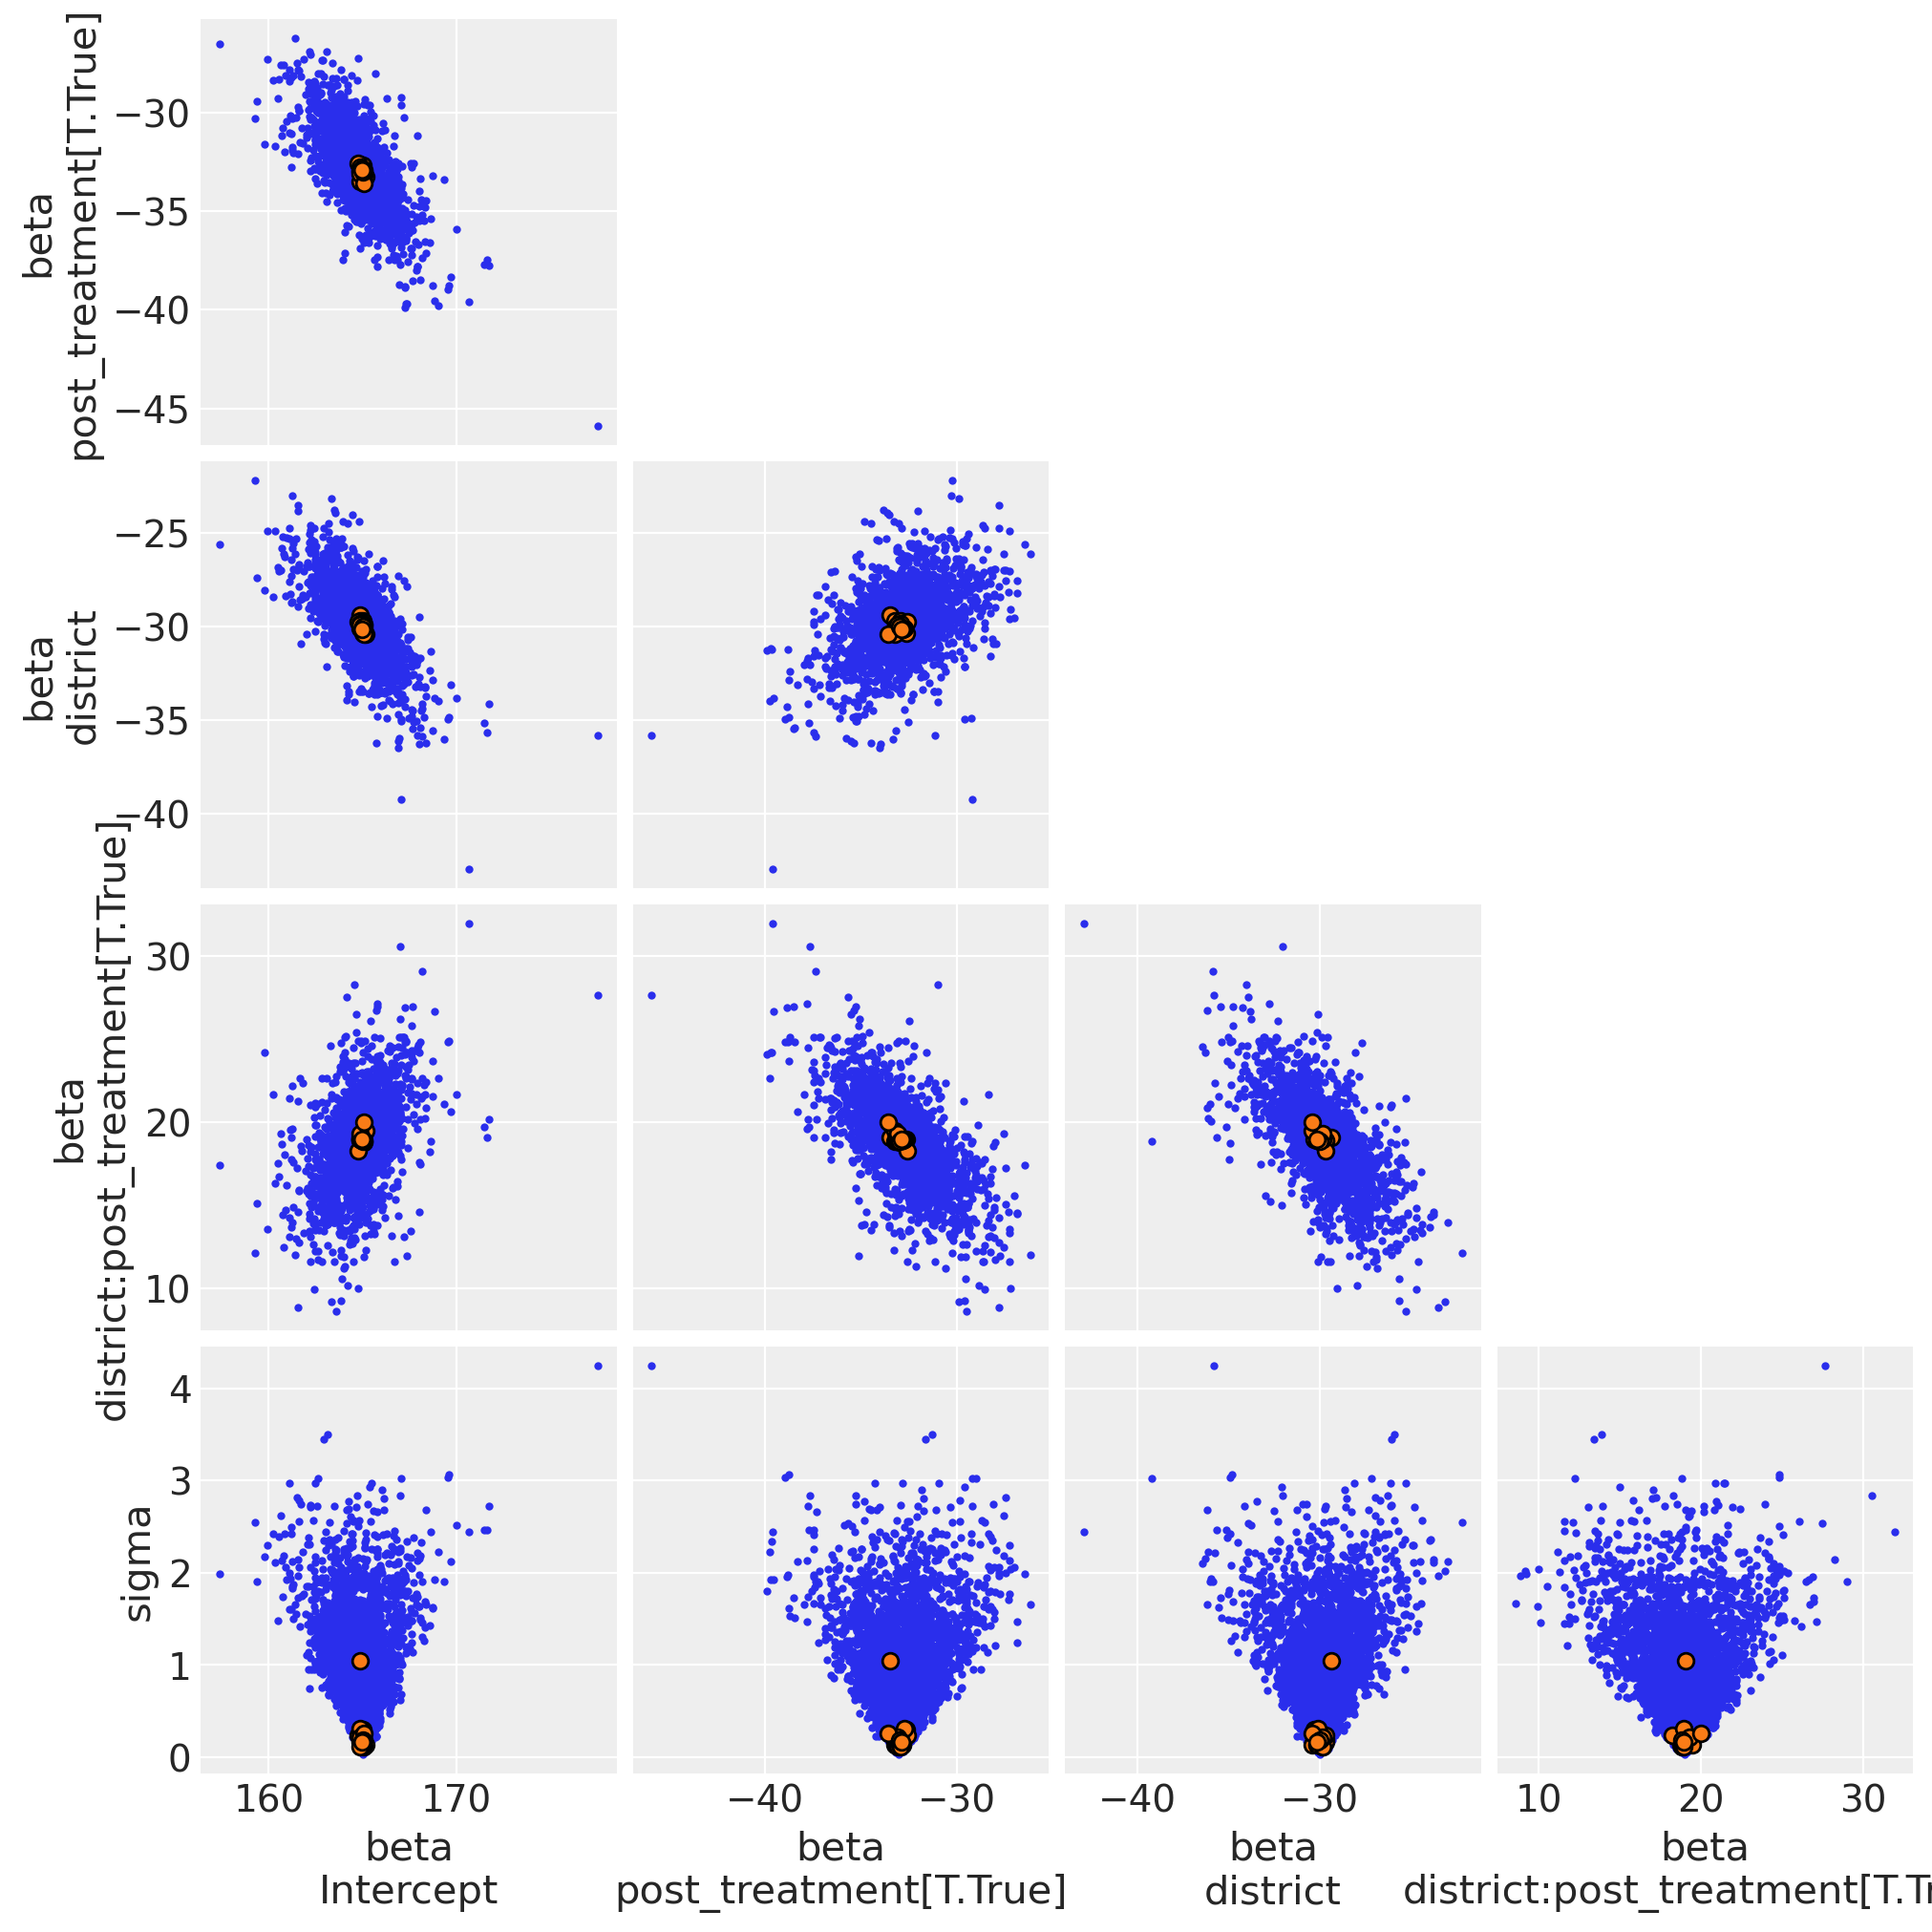

In [7]:
az.plot_pair(result1.idata, var_names="~mu", divergences=True, figsize=(10, 10));

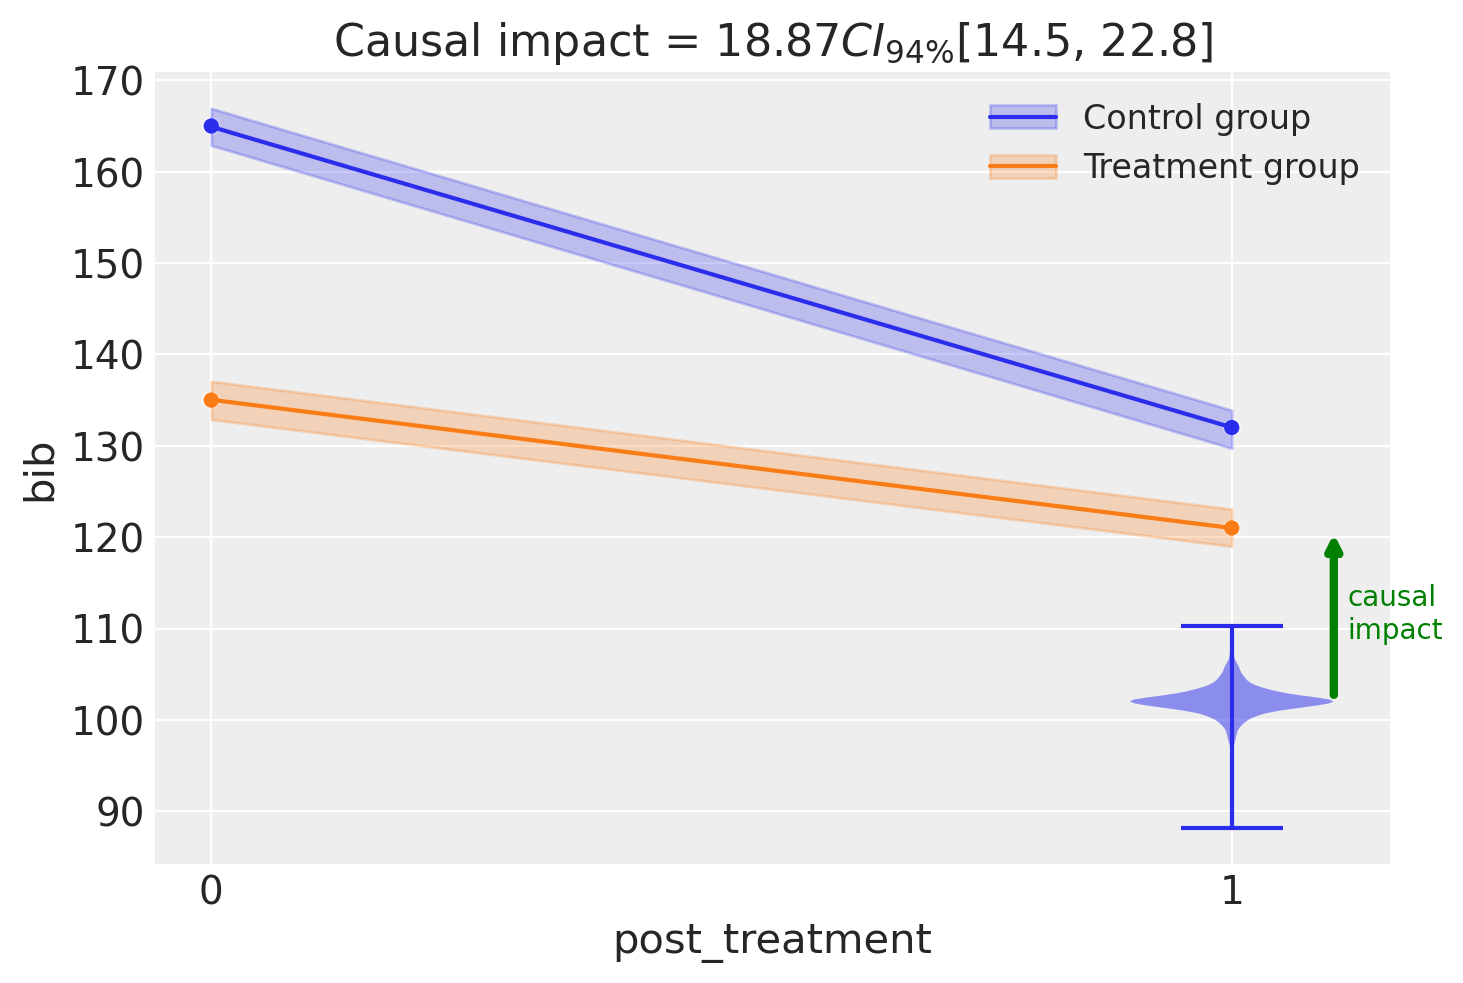

In [8]:
fig, ax = result1.plot(round_to=3)

In [9]:
result1.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + district * post_treatment

Results:
Causal impact = 18.87$CI_{94\%}$[15, 23]
Model coefficients:
    Intercept                        165, 94% HDI [163, 167]
    post_treatment[T.True]           -33, 94% HDI [-36, -30]
    district                         -30, 94% HDI [-33, -27]
    district:post_treatment[T.True]  19, 94% HDI [15, 23]
    sigma                            0.86, 94% HDI [0.16, 2.2]


## Analysis 2 - same model, but with more data

Now lets use the same model but provide observations of all years, not just the years immediately before and after the intervention. This will give us more data to work with.

In [10]:
result2 = cp.DifferenceInDifferences(
    df_long,
    formula="bib ~ 1 + district * post_treatment",
    time_variable_name="post_treatment",
    group_variable_name="district",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.98, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [11]:
result2.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + district * post_treatment

Results:
Causal impact = 19.27$CI_{94\%}$[8.7, 30]
Model coefficients:
    Intercept                        166, 94% HDI [160, 173]
    post_treatment[T.True]           -48, 94% HDI [-55, -40]
    district                         -28, 94% HDI [-37, -19]
    district:post_treatment[T.True]  19, 94% HDI [8.7, 30]
    sigma                            4.6, 94% HDI [3.9, 5.6]


You can see form the table above that the inferred parameters are very similar to the results in {cite:p}`angrist2014mastering` (p. 188). Any discrepancies are due to the fact that we have a Bayesian model with priors over the parameters.

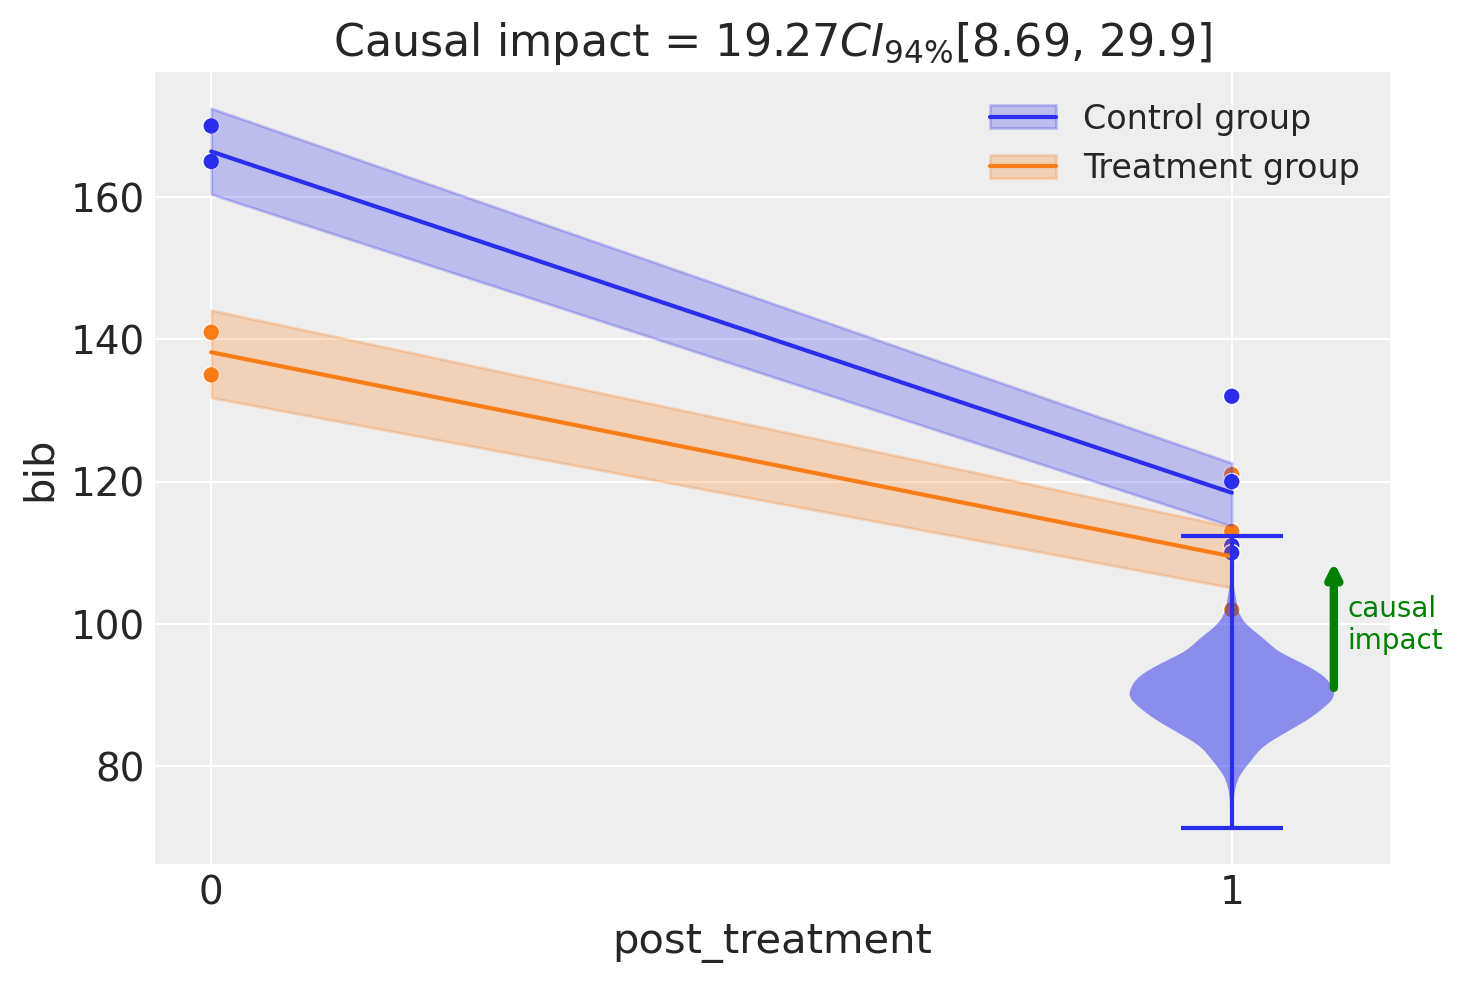

In [12]:
fig, ax = result2.plot(round_to=3)

Let's be clear about what is happening here. Both from the model equation and the plot above, we can see that the modeling approach is to simply pool all the pre intervention observations into the $post=0$ group and all the post intervention observations into the $post=1$ group. So we are essentially modeling the $2\times 2$ group means (as we did before), but with more data per cell.

On the one hand, this could be considered a more robust analysis. But we can see from the raw data that there is a clear temporal trend in the data - the number of banks in business is decreasing over time. Simply averaging the data in pre or post groups will not account for this trend.

## Analysis 3 - Modeling the temporal trend

We'll again do a difference in differences analysis of the full dataset. This approach has similarities to {term}`CITS` (Comparative Interrupted Time-Series) with a single control over time. Although slightly arbitrary, we distinguish between the two techniques on whether there is enough time series data for CITS to capture the time series patterns.

We will use the formula: `bib ~ 1 + year + district*post_treatment` which equates to the following model of expected values:

$$
\begin{aligned}
\mu_i & = \beta_0 \\
 & \quad + \beta_{y} \cdot year_i \\
 & \quad + \beta_{d} \cdot district_i \\
 & \quad + \beta_{p} \cdot post~treatment_i \\
 & \quad + \beta_{\Delta} \cdot district_i \cdot post~treatment_i
\end{aligned}
$$

The only change here compared to the classic 2$\times$2 DiD model above is the addition of a main effect of `year`. Because this is coded numerically (not categorically) this can capture any linear changes in the outcome variable over time.

In [13]:
result3 = cp.DifferenceInDifferences(
    df_long,
    formula="bib ~ 1 + year + district*post_treatment",
    time_variable_name="year",
    group_variable_name="district",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


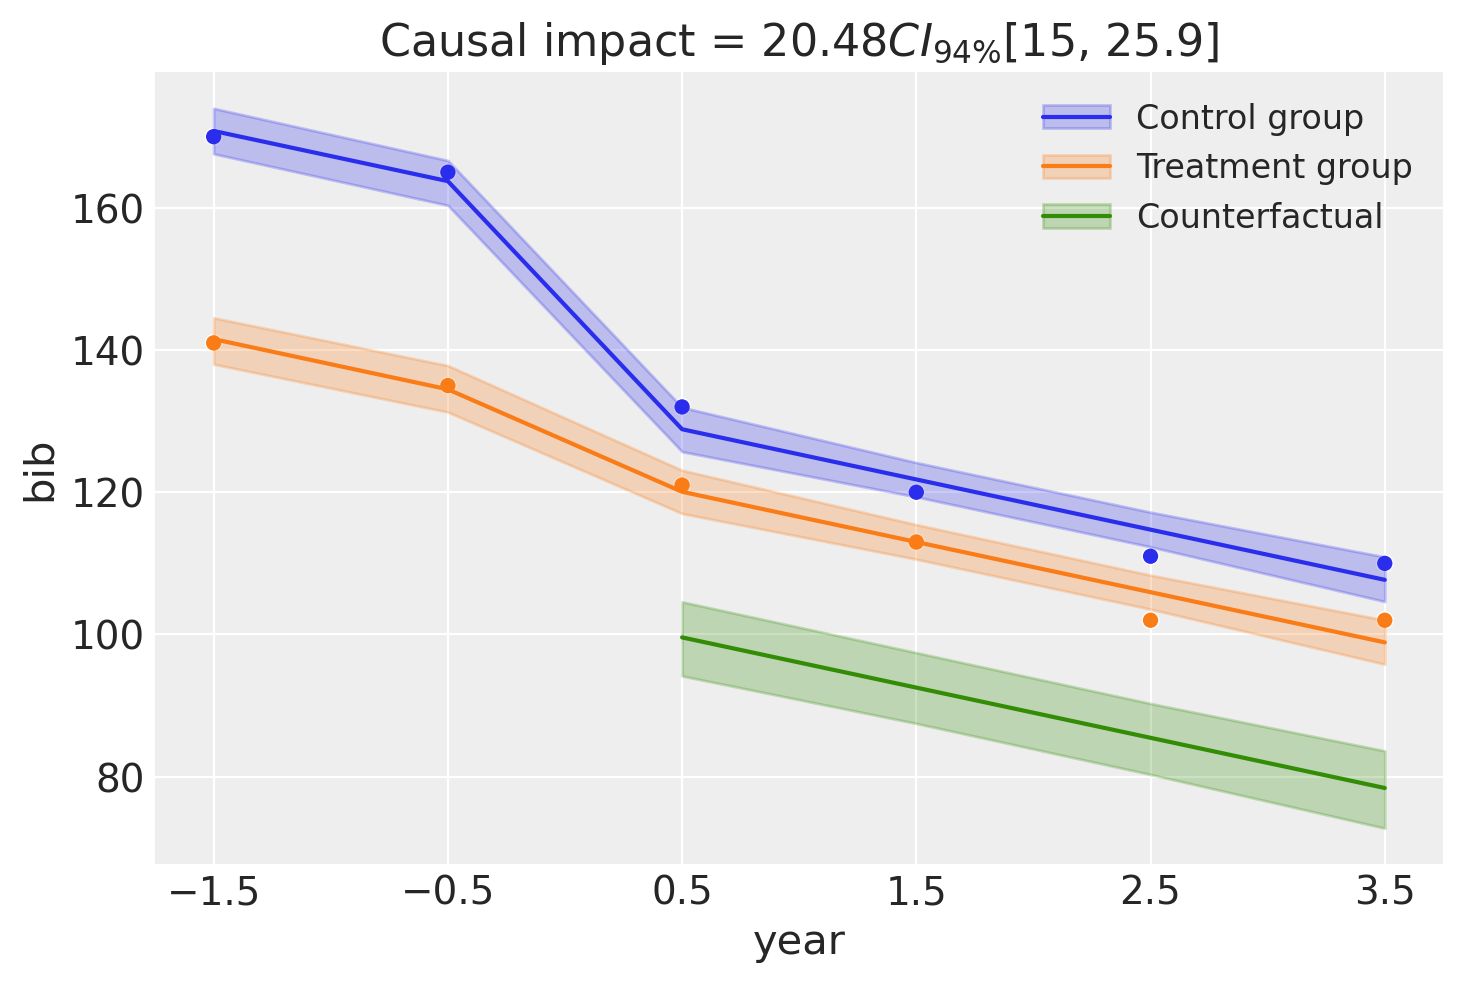

In [14]:
fig, ax = result3.plot(round_to=3)

Because we are now modeling time explicitly, we have year (relative to the intervention) on the x-axis. We can also see that the model clearly does a good job of capturing the temporal trend in the data.

In [15]:
result3.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + year + district*post_treatment

Results:
Causal impact = 20.48$CI_{94\%}$[15, 26]
Model coefficients:
    Intercept                        160, 94% HDI [157, 164]
    post_treatment[T.True]           -28, 94% HDI [-33, -22]
    year                             -7.1, 94% HDI [-8.4, -5.7]
    district                         -29, 94% HDI [-34, -25]
    district:post_treatment[T.True]  20, 94% HDI [15, 26]
    sigma                            2.4, 94% HDI [1.7, 3.2]


By looking at the interaction term, which captures the causal impact of the intervention, we can see that it looks like about 20 banks were saved by the intervention. Though there is some uncertainty around this, we can see the full posterior estimate of this impact below.

## Analysis 4 - Two way fixed effects

Finally, we can evaluate the difference in difference model in its two-way fixed effects (TWFE) formulation. The two-way fixed effects model is widely used in econometrics for causal inference in panel data settings. It accounts for both unit-specific effects (e.g., differences between districts) and time-specific effects (e.g., shocks or trends affecting all units simultaneously). 

The TWFE model is equivalent to the classic 2$\times$2 DiD model (Model 1) - but only in the situation of two groups and two time periods. Outside of this special case the approach is not equivalent and can potentially have some problems {cite:p}`imai2021twfepanel`. Readers should proceed with caution when using the TWFE model outside of the 2$\times$2 case - see {cite:t}`kropko2018two`.

The TWFE approach similar to the previous model in that the `district:post_treatment` interaction term still gives you a treatment indicator variable and the assiated coefficient $\beta_{\Delta}$ is the causal effect of the intervention. But it is different in that there is no _linear_ `year` term, instead we have a _categorical_ `year` variable. This means that the model can capture any temporal trends in the data. These can be thought of as capturing time based schocks that affect all units.

The equation for the expected values is:

$$
\begin{aligned}
\mu_i & \quad + \alpha[district_i] \qquad \textcolor{salmon}{\text{(unit fixed effect)}}\\
 & \quad + \beta[year_i] \qquad \textcolor{salmon}{\text{(time fixed effect)}}\\
 & \quad + \Delta \cdot district_i \cdot post~treatment_i \qquad \textcolor{salmon}{\text{(treatment indicator)}}
\end{aligned}
$$

Typically the TWFE model is presented in matrix form, so the equation above might look less familiar. It has been adapted for long format data. In particular, note that:
* $\alpha$ is a scalar intercept term.
* $\alpha[district_i]$ is a vector of fixed effects for each district. There are only 2 districts, so this is a vector of length 2. The $district_i$ indexes the element of $\alpha$ that corresponds to the district of the $i^{th}$ observation.
* $\beta[year_i]$ is a vector of fixed effects for each year. There are 6 years, so this is a vector of length 6. The $year_i$ indexes the element of $\beta$ that corresponds to the year of the $i^{th}$ observation.
* $\Delta$ is a scalar representing the treatment effect, which is the same as the coefficient of the `district:post_treatment` interaction term.

In [16]:
result_twfe = cp.DifferenceInDifferences(
    df_long,
    formula="bib ~ 0 + district + C(year) + district:post_treatment",
    time_variable_name="year",
    group_variable_name="district",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

# TODO: ideally we would be able to use `unit` instead of `district`

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


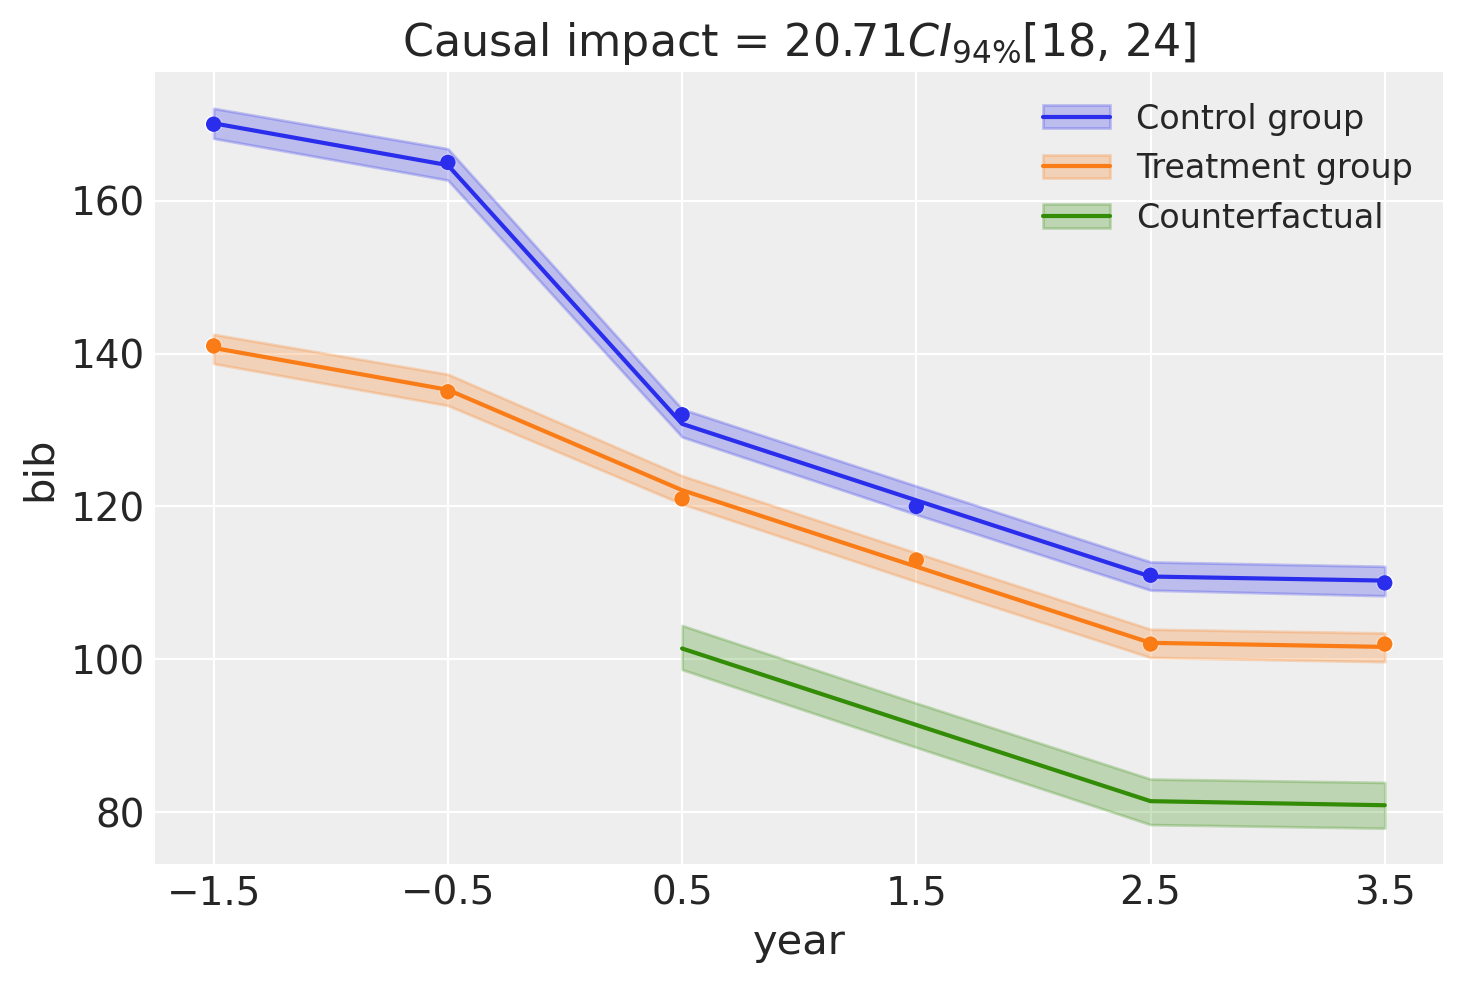

In [17]:
result_twfe.plot();

In [18]:
result_twfe.summary()

===========================Difference in Differences============================
Formula: bib ~ 0 + district + C(year) + district:post_treatment

Results:
Causal impact = 20.71$CI_{94\%}$[18, 24]
Model coefficients:
    C(year)[-1.5]                    170, 94% HDI [168, 172]
    C(year)[-0.5]                    165, 94% HDI [163, 167]
    C(year)[0.5]                     131, 94% HDI [129, 133]
    C(year)[1.5]                     121, 94% HDI [119, 123]
    C(year)[2.5]                     111, 94% HDI [109, 113]
    C(year)[3.5]                     110, 94% HDI [108, 112]
    district                         -29, 94% HDI [-32, -27]
    district:post_treatment[T.True]  21, 94% HDI [18, 24]
    sigma                            1.2, 94% HDI [0.64, 2]


## Comparison of the estimated causal effect

We can compare the posterior mean and precision of the estimated causal effect from the three analyses above.

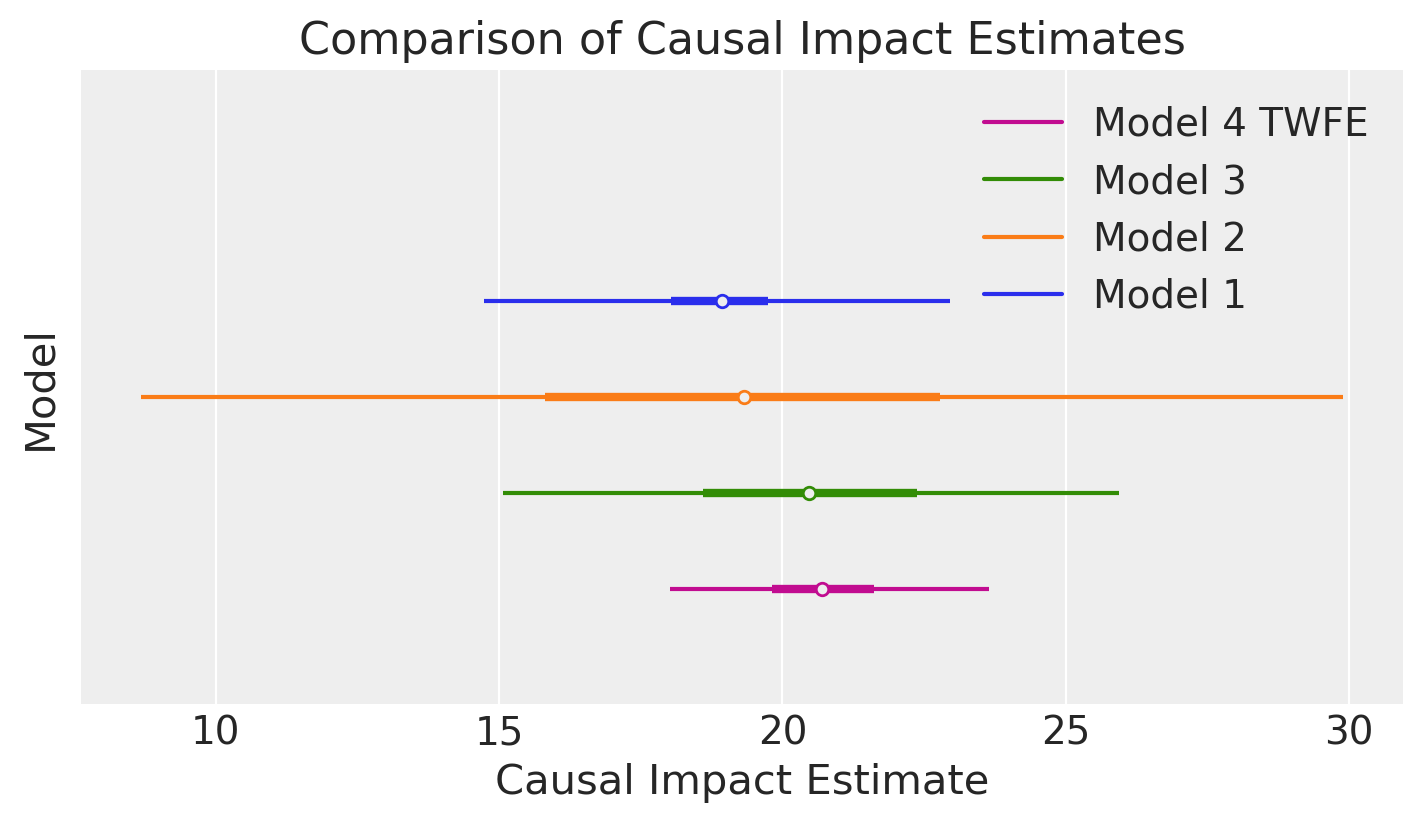

In [19]:
ax = az.plot_forest(
    [
        result1.causal_impact,
        result2.causal_impact,
        result3.causal_impact,
        result_twfe.causal_impact,
    ],
    model_names=["Model 1", "Model 2", "Model 3", "Model 4 TWFE"],
    combined=True,
    figsize=(7, 4),
    hdi_prob=0.94,
)

ax[0].set(
    title="Comparison of Causal Impact Estimates",
    xlabel="Causal Impact Estimate",
    ylabel="Model",
    yticklabels="",
);

We can see that Model 3 (which models the temporal trend) gives a more precise estimate of the causal effect than Model 2 (which simply pools the pre and post intervention data). 

In turn, Model 4 (the two-way fixed effects model) gives a more precise estimate than Model 3. This is because Model 3 assumes a linear trend - but looking at the data we can see that the final observation deviates a bit from a linear trend. The two-way fixed effects model can capture any time-based shocks that affect all units, which is not possible in the previous models. Though it does so at the cost of increased numbers of model parameters.

:::{warning}
The estimate from Model 1 should currently be considered as unreliable. This will be improved in the near future.
:::

## References
:::{bibliography}
:filter: docname in docnames
:::